# Лабораторная работа №3 (Ким Д.В., группа БПМ-151)
## Вариант 13

In [1]:
import numpy as np
import numpy.linalg as lnl
import matplotlib.pyplot as plt
from copy import deepcopy

%matplotlib inline

In [2]:
import time
from tqdm import *

## Задача 3.1
### Условие:
Дана система уравнений $Ax = b$ порядка $n$. Исследовать зависимость погрешности решения $x$ от
погрешностей правой части системы $b$.
Компоненты вектора $b$ во всех вариантах задаются формулой $b_i = N\;\forall\;i = 1...n$, <br/> 
коэффициенты $c = c_{ij} = 0.1\cdot N \cdot i \cdot j\;\;\forall\;\;i,\;j = 1...n$, <br/>
$N = 13\;- $ номер варианта.<br/>
$n = 5$ <br/>
$a_{ij} = \frac{1}{(1+c)^3}$

#### Дано:

In [3]:
n = 5
N = 13

### Пункт 1
Зададим матрицу $A$ и вектор $b$.

In [4]:
def a_ij(i, j):
    return 1/(1+0.1*N*i*j)**3

In [5]:
A = np.asarray([[a_ij(i, j) for i in range(1, n+1)] for j in range(1, n + 1)])
print(A)
print(A.shape)

[[8.21895291e-02 2.14334705e-02 8.49985975e-03 4.19589809e-03
  2.37037037e-03]
 [2.14334705e-02 4.19589809e-03 1.46741172e-03 6.74971516e-04
  3.64431487e-04]
 [8.49985975e-03 1.46741172e-03 4.88189953e-04 2.18612875e-04
  1.16074926e-04]
 [4.19589809e-03 6.74971516e-04 2.18612875e-04 9.65229350e-05
  5.08052634e-05]
 [2.37037037e-03 3.64431487e-04 1.16074926e-04 5.08052634e-05
  2.65990165e-05]]
(5, 5)


In [6]:
b = np.full((n, 1), float(13))
b

array([[13.],
       [13.],
       [13.],
       [13.],
       [13.]])

Красиво рисуем матрицы с помощью функции с гитхаба.

In [7]:
def draw_matrix(_A, ax, precision = 10):
    
    res = ax.imshow(np.array(_A), cmap=plt.cm.PiYG, interpolation='nearest')

    width, height = _A.shape

    for x in range(width):
        for y in range(height):
            ax.annotate(str(_A[x, y])[:precision], xy=(y, x), horizontalalignment='center', verticalalignment='center')

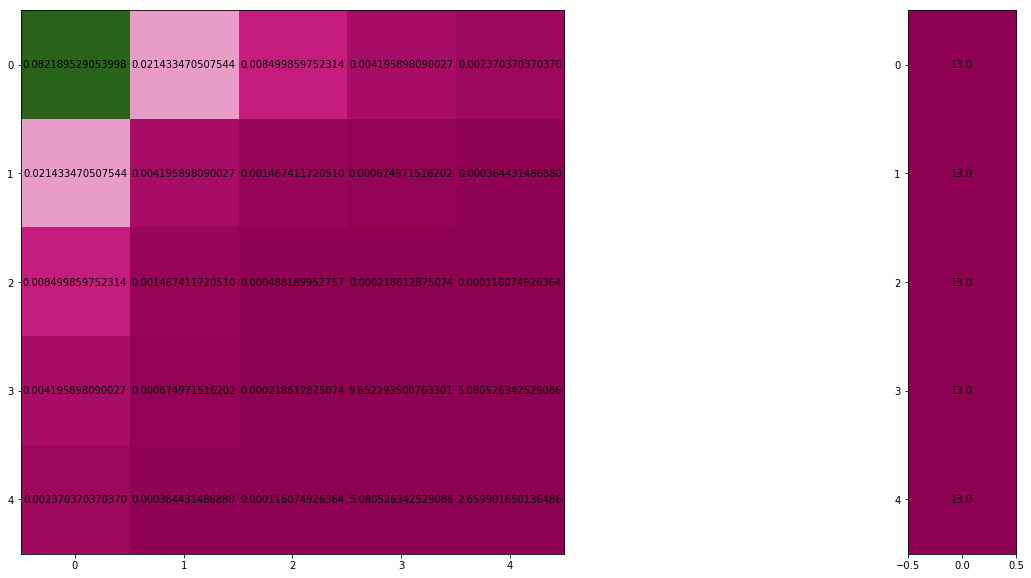

In [8]:
fig = plt.figure(figsize=(22, 22))

# отобразим матрицу А
ax = fig.add_subplot(221)

draw_matrix(A, ax, precision=17)
    
ax = fig.add_subplot(222)

# отображаем вектор b
draw_matrix(b, ax)

Определим функцию, которая реализует метод Гаусса.

In [9]:
def gepp(A, b):
    _A = deepcopy(A)
    _b = deepcopy(b)
    n = _A.shape[0]
    Ab = np.hstack((_A, _b))
    # прямой ход: преобразуем матрицу к угловой
    for k in range(n - 1):
        # ищем k-й главный элемент (максимальный элемент с номером k, 1)
        # ищем номер ряда элемента, а не само значение (но, думаю, это понятно)
        pivot = np.argmax(abs(Ab[k:, k])) + k
        if Ab[pivot, k] == 0:
            print('Singular')
            return -1
        # 'поднимаем' ряд
        Ab[[pivot, k], :] = Ab[[k, pivot], :]
        mu = Ab[k + 1:, k] / Ab[k, k]
        Ab[k + 1:, :] -= Ab[k, :] * mu[:, np.newaxis]
        
    # обратный ход: выражаем ответы через коэффициенты новой верхнеугловой матрицы
    x = np.zeros((n, 1))
    x[-1] = Ab[-1, -1] / Ab[-1, -2]
    for k in range(n-2, -1, -1):
        x[k] = (Ab[k, -1] - np.dot(Ab[k, k + 1:n], x[k+1:])) / Ab[k, k]
    return x

Вычислим ответ...

In [10]:
answer = gepp(A, b)
answer

array([[ 3.22690979e+06],
       [-3.28792209e+08],
       [ 3.96447513e+09],
       [-1.23505436e+10],
       [ 1.05072578e+10]])

...и проверим его встроенной функцией numpy.

In [11]:
x = lnl.solve(A, b)
x

array([[ 3.22690979e+06],
       [-3.28792209e+08],
       [ 3.96447513e+09],
       [-1.23505436e+10],
       [ 1.05072578e+10]])

Видим, что ответы получились очень большими. 

### Пункт 2.
Получим число обусловленности матрицы $A$ при помощи встроенной функции numpy. 

In [12]:
cond = np.linalg.cond(A)
cond

1040230098.292754

Матрица плохо обусловлена, т.к. $cond>>1$

### Пункт 3
Найдем вектор $d = (d_1,..., d_n)^T$, где $d_i = \frac{||x-x^i||_{\infty}}{||x||_{\infty}}$, $i = 1,...,n$ относительных погрешностей решений $x^i$ систем $Ax^i = b^i$, $i = 1,...,n$.<br/>
Компоненты векторов $b^i$ вычисляются по формулам: <br/>
$b_{k}^{i} = \begin{equation*}
\begin{cases}
b_k + \Delta,\;k = i
\\
b_k,\;k \neq i
\end{cases}
\end{equation*}$ 
$k = 1,...,n$<br/>
где $\Delta - $ произвольная величина погрешности.

In [13]:
b.reshape(1, -1)[0]

array([13., 13., 13., 13., 13.])

In [14]:
delta = 1e-4 # произвольная величина погрешности
d = np.zeros(n) # инициализируем вектор d
# инициализируем матрицы для хранения b и x со звездочкой
b_star = np.zeros((n, len(b))) # матрица с векторами b_i, у каждого из которых есть отклонение на delta в i-ом компоненте
x_star = np.zeros((n, len(b))) # матрица с получившимися решениями для системы с вектором b_i справа
for j in range(len(d)):
    b_star[j] = np.copy(b.reshape(1, -1)[0]) # вставляем в матрицу b_star копию исходного вектора
    b_star[j, j] += delta # прибавляем delta к i-му компоненту строки
    x_star[j] = np.copy(lnl.solve(A, b_star[j])) # вставляем решение для системы с отклонением в строку матрицы x_star
    d[j] = lnl.norm((x.reshape(1, -1)[0] - x_star[j]), np.inf)/ lnl.norm(x, np.inf) #считаем относительную погрешность решения
d

array([1.20432842e-08, 1.32339220e-06, 1.63728537e-05, 5.16695402e-05,
       4.43003431e-05])

Посмотрим на матрицу решений для системы с отклонениями.

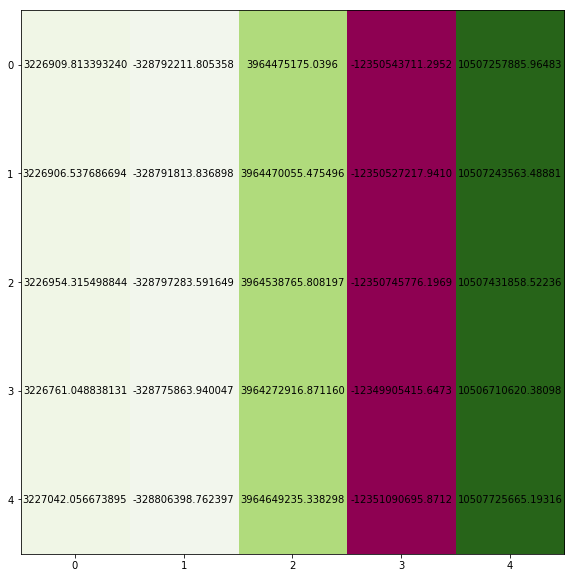

In [15]:
fig = plt.figure(figsize=(22, 22))
ax = fig.add_subplot(221)
draw_matrix(x_star, ax, precision=17)

### Пункт 4
Строим гистограмму.

Наибольший вес имеет элемент вектора b с номером 4


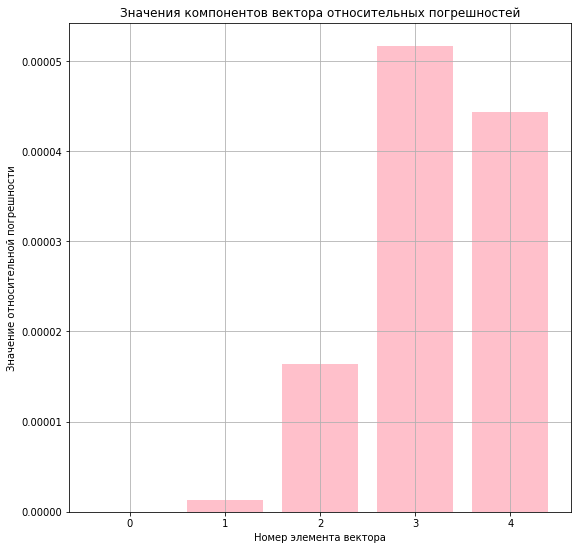

In [16]:
plt.figure(figsize=(9, 9))

plt.title('Значения компонентов вектора относительных погрешностей')

plt.bar(np.arange(len(d)), d.reshape(1, -1)[0], color = 'pink')
plt.ylabel('Значение относительной погрешности')
plt.xlabel('Номер элемента вектора')

plt.grid(True)

print('Наибольший вес имеет элемент вектора b с номером {:d}'.format(np.argmax(d)+1))

plt.show()

### Пункт 5
Оценим погрешность решения $x^m$ по формуле: 
<center>$\delta(x^m) \leq cond(A)\cdot\delta(b^m)$<center/>

Сравним значение $\delta(x^m)$ со значением практической погрешности $d_m$.

In [17]:
delta_b = lnl.norm(b - b_star[np.argmax(d)].reshape(-1, 1), np.inf) / lnl.norm(b, np.inf) # относительное отклонение вектора b 
x_star = lnl.solve(A, b_star[np.argmax(d)].reshape(-1, 1)) # решение с самым большим абсолютным отклонением
delta_x = lnl.norm((x - x_star), np.inf) / lnl.norm(x, np.inf) # относительное отклонение решения x

print('Значение отн. отклонения delta(x^m) = {:.5f}, неравенство: {:.5f} < {:.5f}*{:.5f} '.format(delta_x, delta_x, lnl.cond(A), delta_b),
      delta_x < lnl.cond(A)*delta_b)

Значение отн. отклонения delta(x^m) = 0.00005, неравенство: 0.00005 < 1040230098.29275*0.00001  True


Очень большое число обусловленности говорит, что все норм.